## Model evaluation

Multi-class classification: stars from 1 to 5

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [ ]:
using Revise
#using TokenizersLite # https://github.com/LiorSinai/TokenizersLite
using TransformersLite

In [ ]:
include("reporting.jl")
include("utilities.jl")
include("training.jl")

update_history! (generic function with 1 method)

In [ ]:
nlabels = 5

5

## Download data

Run `python download_amazon_reviews.py`.

Requires Python and the `datasets` package by HuggingFace.

## Load data

raw

In [ ]:
path = "datasets\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
fingerprint = readdir(path)[1]
filepath = joinpath(path, fingerprint, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [ ]:
nrow(df)

200000

filtered

In [ ]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


In [ ]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
directory = "../outputs/20230701_1856_n5_none"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => identity
  :indexer   => IndexTokenizer{String}(length(vocabulary)=6654, unksym=[UNK])
  :model     => TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{…

In [ ]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
model = saved_objects[:model]
display(model)

tokenizer = identity
indexer = IndexTokenizer{String}(length(vocabulary)=6654, unksym=[UNK])


TransformerClassifier(
  Embed((32, 6654)),                    # 212_928 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(50 => 5),                       # 255 parameters
)        # Total: 21 trainable arrays, 225_920 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1009.188 KiB.

In [ ]:
max_length = size(model.classifier.weight, 2)

50

## Tokenizers

In [ ]:
@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents) #takes about 30 seconds for all documents
@time indices = indexer(tokens) #takes about 12 seconds for all documents

y_train = copy(labels)
idxs = Base.OneTo(length(labels))
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = Flux.onehotbatch(y_train, 1:5) # multi-class
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

  6.378982 seconds (28.55 M allocations: 1.767 GiB, 13.45% gc time, 5.01% compilation time)
 17.618740 seconds (56.55 k allocations: 80.689 MiB, 0.39% compilation time)
train samples:      (50, 180000) (5, 180000)
validation samples: (50, 20000) (5, 20000)


In [ ]:
y_test = copy(labels_test)
y_test = Flux.onehotbatch(y_test, 1:5);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.148144 seconds (754.34 k allocations: 47.265 MiB, 36.85% compilation time)
  0.396125 seconds (4 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 5000) (5, 5000)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=64, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=64, shuffle=false);

## Evaluate

In [ ]:
loss(x, y) = Flux.logitcrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])
accuracy(ŷ, y) = mean(Flux.onecold(ŷ) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [ ]:
@time batched_metric(accuracy, train_data_loader, g=model)

 61.167783 seconds (39.26 M allocations: 56.832 GiB, 8.67% gc time, 19.42% compilation time)


0.5588666666666666

In [ ]:
@time batched_metric(accuracy, val_data_loader, g=model)

  6.192460 seconds (62.30 k allocations: 6.101 GiB, 8.62% gc time)


0.5186

In [ ]:
history = open(joinpath(directory, "history.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[1.19395, 1.14122, 1.10483, 1.08572, 1.07348, 1.05601, 1.0…
  "train_acc"  => Any[0.472928, 0.499378, 0.515772, 0.526306, 0.5311, 0.539883,…
  "val_acc"    => Any[0.46865, 0.4891, 0.5033, 0.5095, 0.5127, 0.51535, 0.5156,…
  "val_loss"   => Any[1.20244, 1.1618, 1.13503, 1.12202, 1.12001, 1.1105, 1.113…

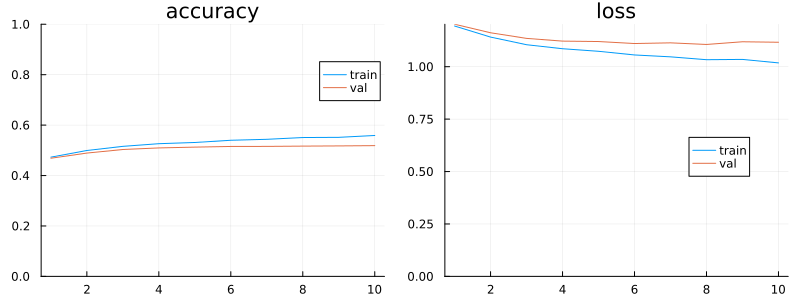

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.8))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
logits = model(X_test)
accuracy(logits, y_test)

0.509

In [ ]:
probs = softmax(logits, dims=1)
y_pred = Flux.onecold(probs);

In [ ]:
cm = confusion_matrix(vec(y_pred), Flux.onecold(y_test), 1:nlabels)

5×5 Matrix{Int64}:
 686  206   56   18   34
 289  385  218   76   32
 138  280  303  224   55
  28   71  202  426  273
  23   34   29  169  745

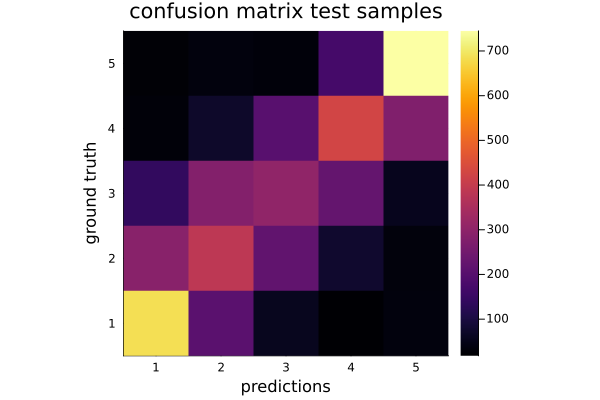

In [ ]:
p = heatmap(1:5, 1:5, cm, xlabel="predictions", ylabel="ground truth", xlims=(0.5, nlabels+0.5), aspectratio=1,
    title="confusion matrix test samples", xticks=(1:5)) #, ["negative", "mix", "positive"]))
savefig(p, joinpath(directory, "confusion_matrix.png"))
p

In [ ]:
classification_report(cm, 1:nlabels)

              precision  recall  f1-score  support
           1       0.59    0.69      0.63     1000
           2       0.39    0.39      0.39     1000
           3       0.38    0.30      0.34     1000
           4       0.47    0.43      0.45     1000
           5       0.65    0.74      0.70     1000

weighted avg       0.50    0.51      0.50     5000

### Examples

In [ ]:
println("star  y  ŷ   prob")
for star in nlabels:-1:1
    pos_max = argmax(probs[star, :])
    @printf("   %1d  %d  %d  %.4f  %s\n\n",
            star, labels_test[pos_max], y_pred[pos_max], probs[star, pos_max], documents_test[pos_max]
        )
end

star  y  ŷ   prob
   5  5  5  0.9843  Best USB cable I ever owned. Fit and finish are top notch. Highly recommended.

   4  4  4  0.8638  I like the case, it works well. I wish it came in purple. The only complaint I have is that it doesn’t charge well on the cordless charger.

   3  3  3  0.6569  seems okay, weaker than i thought it be be and too tight

   2  2  2  0.6974  Returning these. They felt really cheap and I usually wear cheap sunglasses so that really says something lol. Felt super thin and flimsy the look was okay.

   1  1  1  0.9908  Scam, never came in!



In [ ]:
nshow = 2

for label in 1:nlabels
    println("\ntrue label = $label")
    idxs = labels_test .== label
    idxs_label = (1:length(labels_test))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            println("-"^100)
            @printf("%4d  %d  %d  %.4f  %s\n",
                idx, labels_test[idx], y_pred[idx], probs[idx], documents_test[idx]
            )
        end
    end
    println("")
end


true label = 1
correct: 686 / 1000
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
 676  1  1  0.8830  Not very happy with this product. Upon opening the package I was hit with an unpleasant chemical smell. Had to air it out for a couple of hours before I let my daughter play with it. She's only had it for a total of 3 days and it's already torn at the neck seam. The black of the penguin smudges to the white. Definitely not worth $8.
----------------------------------------------------------------------------------------------------
 186  1  1  0.6452  Worst fucking item I ever bought on Amazon I had a headache for 2 days on this bullshit I thought I had to go to the emergency room please don't but real costumer
----------------------------------------------------------------------------------------------------
 466  1  2  0.9460  When you pour the body wash on the bristles it doesn't foam up. No matter how much

### Probabilities

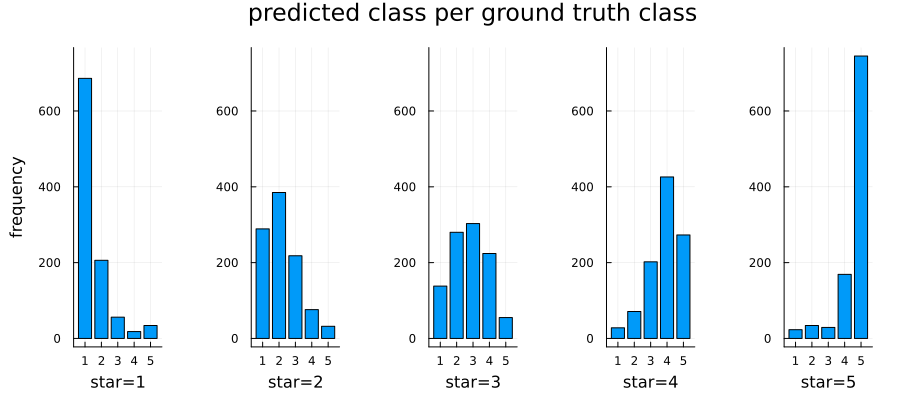

In [ ]:
canvases = []
label_names = 1:5
for gt_star in 1:5
    idxs = labels_test .== gt_star
    value_counts = [sum((y_pred[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="star=$gt_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted class per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "prediction_star.png"))
p

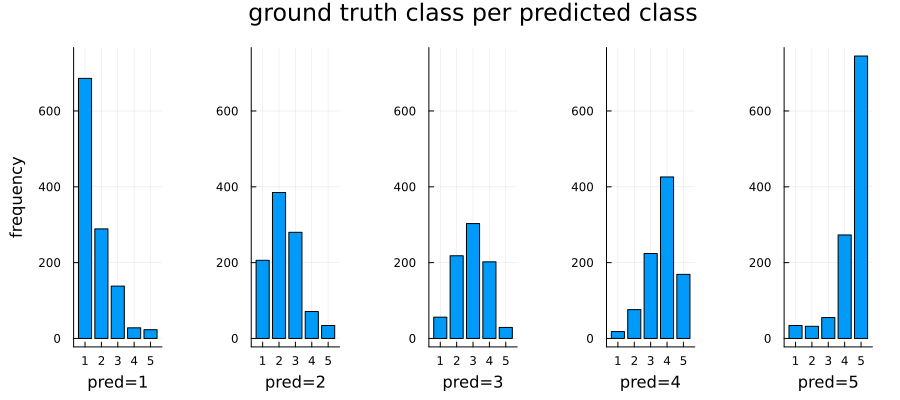

In [ ]:
canvases = []
label_names = 1:5
for pred_star in 1:5
    idxs = y_pred .== pred_star
    value_counts = [sum((labels_test[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="pred=$pred_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="ground truth class per predicted class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "star_prediction.png"))
p

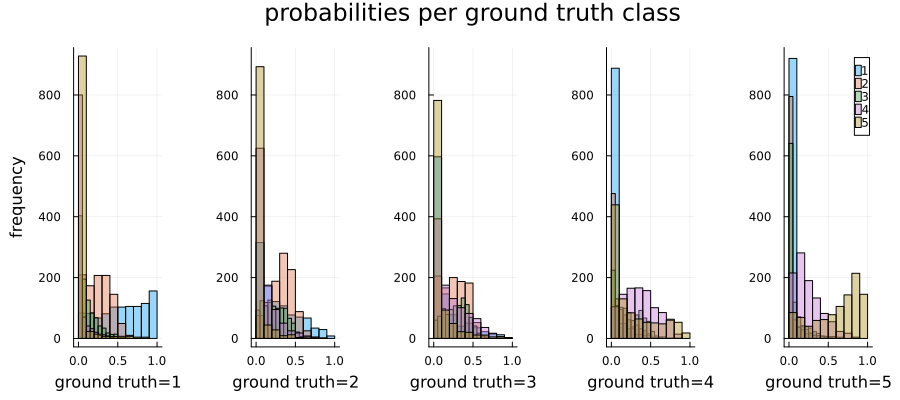

In [ ]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        histogram!(probs_star[pred_star, :], fillalpha=0.4, label=label_names[pred_star], nbins=12)
    end
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star.png"))
p

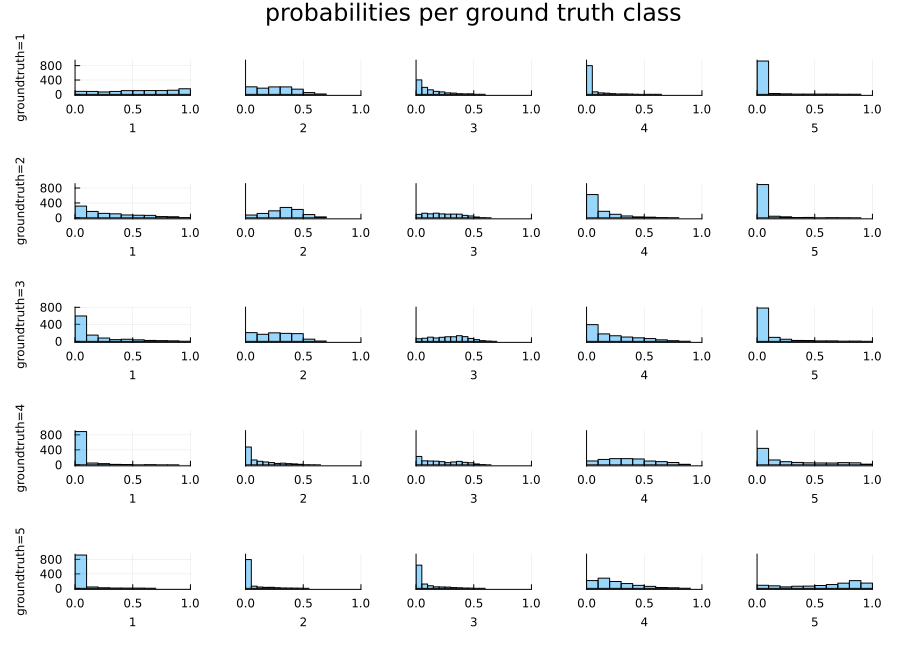

In [ ]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    #p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        p = histogram(probs_star[pred_star, :], fillalpha=0.4, label="", nbins=12,  
            xlims=[0, 1], xticks=([0.00, 0.50, 1.00]), yticks=([]), xlabel="$pred_star", xguidefontsize=8)
        push!(canvases, p)
    end
end

for groundtruth_star in 1:5
    plot!(canvases[1 + 5 * (groundtruth_star - 1)], ylabel="groundtruth=$groundtruth_star", yguidefontsize=8,
        yticks=([0, 400, 800])
    )
end
    
p =plot(canvases..., layout=(5, 5), link=:y, size=(900, 650), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star_grid.png"))
p

### Single sample

In [ ]:
idx = 4600 

d = documents_test[idx]
println(labels_test[idx])
println(d)
println("")

tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
println("")

x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
I used for a party and was great !

used|for|party|and|was|great

89|7|764|4|14|29|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1


In [ ]:
model.embed(x)

32×50 Matrix{Float32}:
  1.05269      0.852232    -0.118734   …   0.584514    0.584514    0.584514
 -1.0285       0.351136    -0.376924       0.077193    0.077193    0.077193
  0.0860291   -0.439082    -0.389732       0.103476    0.103476    0.103476
  0.885977    -3.20814     -0.198904      -0.100401   -0.100401   -0.100401
  0.492928     0.842826    -1.45368        0.0994263   0.0994263   0.0994263
  0.460959    -0.295897     1.58943    …  -0.163967   -0.163967   -0.163967
 -0.0178768   -1.21642     -2.00626        0.816945    0.816945    0.816945
 -1.26323      0.300514     0.825885      -0.857695   -0.857695   -0.857695
 -0.037113    -0.618971     1.11775       -0.661395   -0.661395   -0.661395
 -0.34109      0.485692    -1.27683        1.23855     1.23855     1.23855
 -1.93013      0.612523     0.304209   …  -0.248842   -0.248842   -0.248842
  0.00471629  -0.147815     0.297198      -0.0294033  -0.0294033  -0.0294033
  0.0745029   -0.967653     0.397894      -0.18685    -0.18685  

In [ ]:
softmax(model(x))

5×1 Matrix{Float32}:
 0.00040808515
 0.0017174999
 0.01038454
 0.19132927
 0.79616064